В этом блокноте мы рассмотрим кратко, как с помощью Gadfly:
1. Cтроить boxplot-ы.
2. Отображать точки из датасета вместе с линейной регрессионной моделью для них.
3. Визуализируем переобучение с помощью Geom.smooth

Замечу, что датасеты и картинки, под которые всё более-менее "подгонялось", были любезно позаимствованы из ISLR :  An Introduction to Statistical Learning with Applications in R; авторы: Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Её бесплатную версию можно найти на просторах интернета, русская версия только платно в магазинах.

In [1]:
using DataFrames

In [2]:
# функция readtable из пакета DataFrames принимает на вход множество параметров
# во-первых, это название файла (с путём)
# во-вторых, разделитель separator - по умолчанию равен запятой (для файлов csv)
# в-третьих, header = true, если в файле csv первой строкой идут имена колонок
df = readtable("../datasets/Advertising.csv", header = true);
# проверим, что всё считалось правильно
head(df)

,x,TV,Radio,Newspaper,Sales
1,1,230.1,37.8,69.2,22.1
2,2,44.5,39.3,45.1,10.4
3,3,17.2,45.9,69.3,9.3
4,4,151.5,41.3,58.5,18.5
5,5,180.8,10.8,58.4,12.9
6,6,8.7,48.9,75.0,7.2


In [3]:
# df имеет тип DataFrame
typeof(df)

DataFrames.DataFrame

In [4]:
# мы будем работать с графикой с помощью Gadfly
using Gadfly

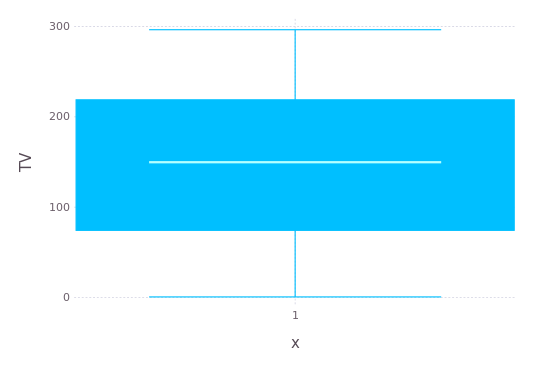

In [5]:
# для начала построим простой boxplot для трат на рекламу на TV
plot(df, x = [1], y = :TV, Geom.boxplot)

А что, если мы хотим получить сразу три boxplot-а на одном графике, чтобы посмотреть, на что тратилось больше денег?

Для этого нам необходимо завести массив, в котором сначала будут все траты на TV с пометкой 1, затем все траты на Radio с пометкой 2, затем траты на газеты с пометкой 3.

In [6]:
numObservations = size(df)[1]
df_payments = zeros((3 * numObservations, 2));

# заполняем первые numObservations значений меткой 1 и тратами на рекламу по TV
df_payments[1 : numObservations, 1] .= 1
df_payments[1 : numObservations, 2] .= df[:, :TV]

# заполняем вторые numObservations значений меткой 2 и тратами на рекламу по Radio
df_payments[numObservations + 1 : 2 * numObservations, 1] .= 2
df_payments[numObservations + 1 : 2 * numObservations, 2] .= df[:, :Radio]

# заполняем третьи numObservations значений меткой 3 и тратами на рекламу в газетах
df_payments[2 * numObservations + 1 : 3 * numObservations, 1] .= 3
df_payments[2 * numObservations + 1 : 3 * numObservations, 2] .= df[:, :Newspaper];

Заметьте, что копирование массивов я производил в виде 
```julia
arr1[..] .= arr2[..]
```
Это принципиальный момент: почему мы используем .= вместо =? 

Для этого предлагаю сравнить два следующих куска кода.

In [7]:
array1 = collect(1 : 10)
array2 = array1
array2[1] = 42
println(array1)
println(array2)

[42, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[42, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Фактически, массивы array1 и array2 ссылаются на один и тот же участок памяти. Если я меняю array2, то меняется и array1.

Теперь такой случай:

In [8]:
array1 = collect(1 : 10)
array2 .= array1
array2[1] = 42
println(array1)
println(array2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[42, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Теперь я покомпонентно скопировал array1 в array2, и при изменении array2 массив array1 не изменяется.

In [9]:
# всё сработало корректно - скопировали в df_payments нужные платежи с метками
df_payments

600×2 Array{Float64,2}:
 1.0  230.1
 1.0   44.5
 1.0   17.2
 1.0  151.5
 1.0  180.8
 1.0    8.7
 1.0   57.5
 1.0  120.2
 1.0    8.6
 1.0  199.8
 1.0   66.1
 1.0  214.7
 1.0   23.8
 ⋮         
 3.0    3.7
 3.0   23.4
 3.0    5.8
 3.0    6.0
 3.0   31.6
 3.0    3.6
 3.0    6.0
 3.0   13.8
 3.0    8.1
 3.0    6.4
 3.0   66.2
 3.0    8.7

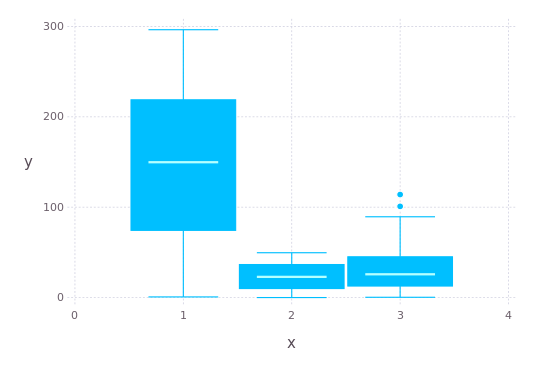

In [10]:
# строим нужные boxplot-ы
plot(x = df_payments[:, 1], y = df_payments[:, 2], Geom.boxplot)

Ту же самую информацию можно получить и проще (хотя и не в таком же наглядном виде): просто применим describe к исходному dataframe.

In [11]:
describe(df[[:TV, :Radio, :Newspaper]])

TV
Summary Stats:
Mean:           147.042500
Minimum:        0.700000
1st Quartile:   74.375000
Median:         149.750000
3rd Quartile:   218.825000
Maximum:        296.400000
Length:         200
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Radio
Summary Stats:
Mean:           23.264000
Minimum:        0.000000
1st Quartile:   9.975000
Median:         22.900000
3rd Quartile:   36.525000
Maximum:        49.600000
Length:         200
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Newspaper
Summary Stats:
Mean:           30.554000
Minimum:        0.300000
1st Quartile:   12.750000
Median:         25.750000
3rd Quartile:   45.100000
Maximum:        114.000000
Length:         200
Type:           Float64
Number Missing: 0
% Missing:      0.000000



Продолжим изучать наш датасет. Теперь попробуем посмотреть, как влияют деньги, вложенные в рекламу на TV, на продажи товара.

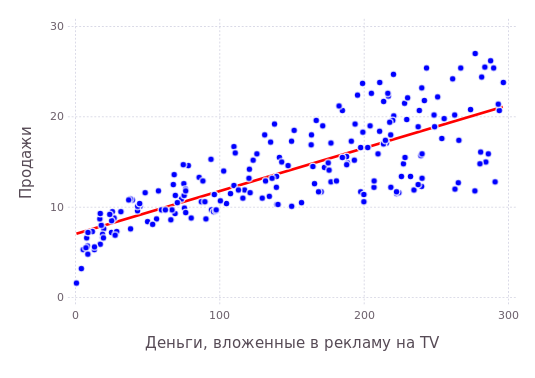

In [12]:
plot(df, x = :TV, y = :Sales,
        layer(Theme(default_color = "blue"), Geom.point),
        layer(Theme(default_color = "red", line_width = 2pt), Geom.smooth(method = :lm)),
        Guide.xlabel("Деньги, вложенные в рекламу на TV"),
        Guide.ylabel("Продажи")
    )

Мы видим, что есть корреляция.

И действительно, подсчитывая корреляционный коэффициент Пирсона, мы получаем, что он довольно большой положительный:

In [13]:
cor(df[:TV], df[:Sales])

0.7822244248616064

В то же время корреляция между количеством денег, потраченных на рекламы в газетах, и количеством денег с продаж не так явно выражена:

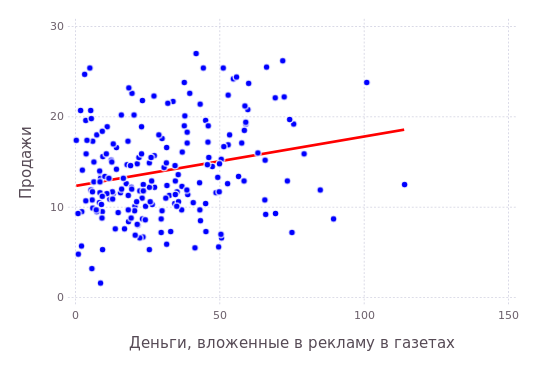

In [14]:
plot(df, x = :Newspaper, y = :Sales,
        layer(Theme(default_color = "blue"), Geom.point),
        layer(Theme(default_color = "red", line_width = 2pt), Geom.smooth(method = :lm)),
        Guide.xlabel("Деньги, вложенные в рекламу в газетах"),
        Guide.ylabel("Продажи")
    )

In [15]:
# ищем корреляцию для Newspapers vs Sales
cor(df[:Newspaper], df[:Sales])

0.22829902637616545

Видим, что корреляция не столь явно выражена.

В заключении посмотрим, как можно графически отобразить "подгонку" функций под наблюдаемые значения (x, y).

Для начала сгенерируем случайные данные, которые являются просто функцией 5sin(x) + гауссовский шум (нормально распределенный, среднее значение равно 0, дисперсия равна 1).

In [16]:
# генерация случайных данных
# xGrid, yGrid - основание для отрисовки функции (сетка значений (x, f(x)))
xGrid = collect(0 : 0.01 : 1.5)
yGrid = 5 .* sin.(xGrid)

# генерируем случайные данные (x, y)
xObservation = 1.5 .* rand(100)
yObservation = 5 .* sin. (xObservation) .+ randn(100);

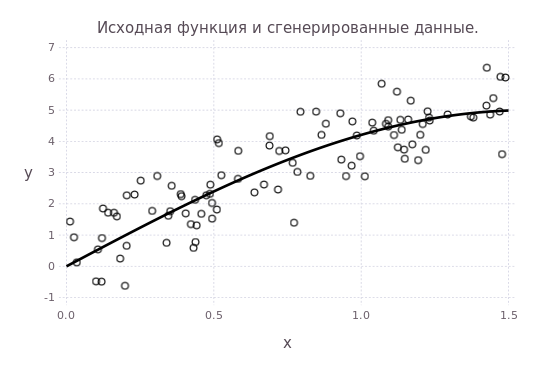

In [17]:
# построение графика
plot(layer(x = xGrid, y = yGrid, Theme(default_color = "black", line_width = 2pt), Geom.line),
     layer(x = xObservation, y = yObservation, 
            Theme(default_color = "transparent", 
            discrete_highlight_color = (x -> Colors.RGBA(0,0,0, 1))), Geom.point),
     Guide.title("Исходная функция и сгенерированные данные.")
    )

Обратите внимание на то, как были получены "прозрачные" точки (в стиле точек из ggplot2):
1. Параметр default_color был установлен transparent, т.е. прозрачный.
2. Необходимо отдельно задать ФУНКЦИЮ discrete_highlight_color, которая должна отображать цвет "заливки" в цвет соответствующей этой границе заливки. В данном случае я любую заливку отображаю в черный цвет - Colors.RGBA(0,0,0,1). Последний параметр отвечает за прозрачность цвета (alpha в терминологии ggplot2)

Теперь построим различные "подгонки" под наблюдаемые данные. Для демонстрации будем использовать Geom.smooth, который строит сплайн (при использовании параметра :loess), при этом передается параметр smoothing $\in [0, 1]$. Чем меньше параметр, тем сильнее сплайн подгоняется под тренировочные данные.

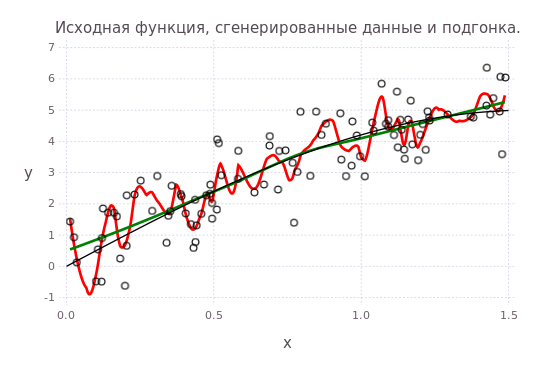

In [18]:
plot(layer(
        x = xGrid, y = yGrid, 
        Theme(default_color = "black", line_width = 1pt), 
        Geom.line),
    
     layer(
        x = xObservation, y = yObservation,
        Theme(default_color = "transparent", 
            discrete_highlight_color = (x -> Colors.RGBA(0,0,0, 1))), 
        Geom.point),
    
     layer(
        x = xObservation, y = yObservation, 
        Theme(default_color = "green", line_width = 2pt),
        Geom.smooth(method=:loess,smoothing=0.9)),
    
     layer(
        x = xObservation, y = yObservation, 
        Theme(default_color = "red", line_width = 2pt), 
        Geom.smooth(method=:loess,smoothing=0.1)),
    
     Guide.title("Исходная функция, сгенерированные данные и подгонка.")
    )

Зеленая подгонка хорошо аппроксимирует исходную функцию. Красная же явно переобучена -- она пытается "ухватить" закономерности данных слишком "рьяно", и в результате сильно реагирует на случайные отклонения.

Рассмотрим ещё один пример.

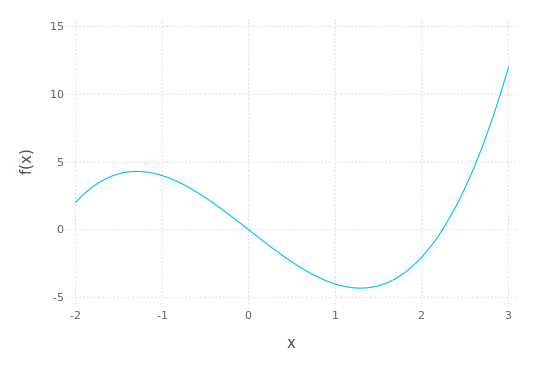

In [19]:
# функция, с помощью которой мы будем генерировать train data
plot(x -> x^3 - 5*x, -2, 3)

In [20]:
# генерация случайных данных
# сетка для построения функции
xGrid = collect(-2 : 0.01 : 3)
yGrid = xGrid.^3 .- 5 .* xGrid

# тренировочные данные
xObservation = 5 .* rand(100) .- 2
yObservation = (xObservation.^3) .- (5 .* xObservation) .+ randn(100);

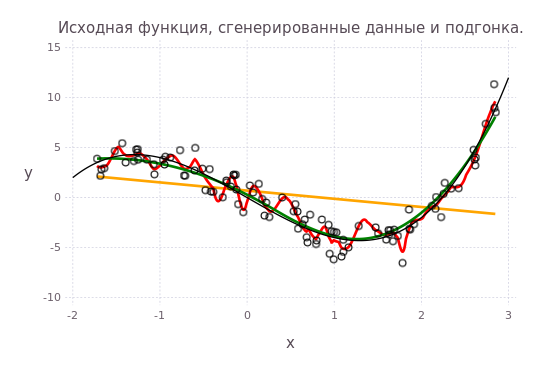

In [21]:
plot(layer(
        x = xGrid, y = yGrid, 
        Theme(default_color = "black", line_width = 1pt), 
        Geom.line),
    
     layer(
        x = xObservation, y = yObservation,
        Theme(default_color = "transparent", 
            discrete_highlight_color = (x -> Colors.RGBA(0,0,0, 1))), 
        Geom.point),
    
     layer(
        x = xObservation, y = yObservation, 
        Theme(default_color = "green", line_width = 2pt),
        Geom.smooth(method=:loess,smoothing=0.9)),
    
     layer(
        x = xObservation, y = yObservation, 
        Theme(default_color = "red", line_width = 2pt), 
        Geom.smooth(method=:loess,smoothing=0.1)),
    
     layer(
        x = xObservation, y = yObservation, 
        Theme(default_color = "orange", line_width = 2pt), 
        Geom.smooth(method=:lm)),     
    
     Guide.title("Исходная функция, сгенерированные данные и подгонка.")
    )

Для сравнения также приведена линейная регрессионная модель (оранжевая линия), которая на данном примере дает очень плохое приближение.